In [1]:
import abc
from collections import *
from dataclasses import dataclass
import enum
import gym
import numpy as np
from typing import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
'''
import pyglet
from pyglet.gl import *

window = pyglet.window.Window(width=300, height=200, display=None)
window.clear()

from gym.envs.classic_control import rendering
viewer = rendering.Viewer(screen_width, screen_height)
'''

# TODO - complexe... first without the maze, find the place to go

# TODO - move through a maze where 1 are blocked, 0 are free, and you must find the end
# TODO - use convolution net to find the right decision
# TODO - reward is -1 for each time your are in the maze

# TODO - make a custom space for actions / states?


class MazeEnv(gym.Env):
    def __init__(self, maze: np.ndarray, start_pos: Tuple[int, int]):
        self.maze: np.ndarray = np.array(maze)
        self.start_pos: Tuple[int, int] = start_pos
        self.end_positions: Set[Tuple[int, int]] = self._find_end_positions(maze)
        self.state = None # Must be immutable? I guess so
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.MultiDiscrete(list(maze.shape))
    
    @property
    def done(self) -> bool:
        return self.state in self.end_positions
    
    def reset(self):
        self.state = self.start_pos
        return self.state
    
    def step(self, action):
        if self.done:
            raise Exception("Game is over")
        self._move(action)
        return self.state, -1, self.done, {}

    def _find_end_positions(self, maze):
        end_positions = set()
        h, w = self.maze.shape
        for i in range(h):
            for j in range(w):
                if self.maze[i, j] == 2:
                    end_positions.add((i, j))
                    self.maze[i, j] = 0
        return end_positions
    
    def _move(self, action):
        i, j = self.state
        h, w = self.maze.shape
        if action == 0:   # UP
            i = max(0, i - 1)
        elif action == 1: # DOWN
            i = min(h - 1, i + 1)
        elif action == 2: # LEFT
            j = max(0, j - 1)
        elif action == 3: # RIGHT
            j = min(w - 1, j + 1)
        if self.maze[i, j] == 0:
            self.state = (i, j)
    
    def render_state(self, zoom: int):
        h, w = self.maze.shape
        m = np.zeros((h, w, 3), 'uint8')
        for i in range(h):
            for j in range(w):
                if self.maze[i, j] == 1:
                    m[i, j, 0] = 255
        for i, j in self.end_positions:
            m[i, j, 1] = 255
        i, j = self.state
        m[i, j, 2] = 255
        image = Image.fromarray(m, 'RGB')
        image = image.resize((w * zoom, h * zoom))
        return image        

In [39]:
class ActionValues(abc.ABC):    
    @abc.abstractmethod
    def get_action_value(self, state, action) -> float:
        pass
    
    def get_best_action(self, state, actions, epsilon: float = 0.):
        if epsilon > 0. and np.random.random() < epsilon:
            return np.random.choice(actions)
        
        best_action = None
        best_score = float('-inf')
        for action in actions:
            score = self.get_action_value(state, action)
            if score > best_score:
                best_score = score
                best_action = action
        return best_action


class DiscreteActionValues(ActionValues):
    def __init__(self,default_value: float = 0., learning_rate: float = 0.1):
        # The default value might help in early exploration (if set in a higher value than what can possibly be)
        self.learning_rate = learning_rate
        self.values = defaultdict(lambda: defaultdict(lambda: default_value))
    
    def add(self, state, action, score: float) -> float:
        self.values[state][action] += self.learning_rate * (score - self.values[state][action])
    
    def get_action_value(self, state, action) -> float:
        return self.values[state][action]

    
class SumOfActionValues(ActionValues):
    def __init__(self, action_values: List[ActionValues]):
        self.action_values = action_values
    
    def get_action_value(self, state, action) -> float:
        return sum(vals.get_action_value(state, action) for vals in self.action_values)
    

class SARSA:
    def __init__(self,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1):
        self.q_values = DiscreteActionValues(default_value=default_value, learning_rate=learning_rate)
        self.reward_discount = reward_discount
        self.epsilon = epsilon
    
    def play_episode(self, env) -> float:
        total_reward = 0.
        state = env.reset()
        done = False
        while not done:
            action = self._behavior_policy_action(env, state)
            new_state, reward, done, info = env.step(action)
            new_action = self._target_policy_action(env, new_state)
            score = reward + self.reward_discount * self.q_values.get_action_value(new_state, new_action)
            self.q_values.add(state, action, score)
            total_reward += reward
            state = new_state
        return total_reward
    
    def get_action(self, env, state):
        return self._target_policy_action(env, state)
    
    def _target_policy_action(self, env, state):
        return self._behavior_policy_action(env, state)
    
    def _behavior_policy_action(self, env, state):
        return self.q_values.get_best_action(state, range(env.action_space.n), self.epsilon)
    
    def name(self):
        return "SARSA"


class QLearning(SARSA):
    def __init__(self,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1):
        super().__init__(default_value=default_value, learning_rate=learning_rate, reward_discount=reward_discount, epsilon=epsilon)
    
    def _target_policy_action(self, env, state):
        return self.q_values.get_best_action(state, range(env.action_space.n))
    
    def name(self):
        return "Q-Learning"
    

class DoubleQLearning:
    def __init__(self,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1):
        self.q_values = [
            DiscreteActionValues(default_value=default_value, learning_rate=learning_rate),
            DiscreteActionValues(default_value=default_value, learning_rate=learning_rate)]
        self.q_values_sum = SumOfActionValues(self.q_values)
        self.reward_discount = reward_discount
        self.epsilon = epsilon
    
    def play_episode(self, env) -> float:
        total_reward = 0.
        state = env.reset()
        done = False
        
        while not done:
            action = self._behavior_policy_action(env, state)
            new_state, reward, done, info = env.step(action)
            
            which_q = np.random.randint(0, 2)
            q1, q2 = self.q_values[which_q], self.q_values[1-which_q]
            new_action = q2.get_best_action(new_state, range(env.action_space.n))
            q2.add(state, action, reward + self.reward_discount * q1.get_action_value(new_state, new_action))
            
            total_reward += reward
            state = new_state
        return total_reward
    
    def get_action(self, env, state):
        return self.q_values_sum.get_best_action(state, range(env.action_space.n))
    
    def _behavior_policy_action(self, env, state):
        if self.epsilon > 0. and np.random.random() < self.epsilon:
            return env.action_space.sample()
        return self.q_values_sum.get_best_action(state, range(env.action_space.n))
    
    def name(self):
        return "Double Q-Learning"

    
class NStepSARSA:
    def __init__(self,
                 depth: int,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1):
        self.depth = depth
        self.q_values = DiscreteActionValues(default_value=default_value, learning_rate=learning_rate)
        self.reward_discount = reward_discount
        self.epsilon = epsilon
    
    def play_episode(self, env) -> float:
        total_reward = 0.
        done = False
        steps = deque()
        
        state = env.reset()
        action = self._behavior_policy_action(env, state)
        while not done:
            new_state, reward, done, info = env.step(action)
            steps.append((state, action, new_state, reward))
            if not done:
                action = self._behavior_policy_action(env, new_state)
                if len(steps) >= self.depth:
                    score, discount, last_state = self._discounted_score(steps)
                    last_action = self._target_policy_action(env, last_state)
                    score += discount * self.q_values.get_action_value(last_state, last_action)
                    first_state, first_action, _, _ = steps.popleft()
                    self.q_values.add(first_state, first_action, score)
            total_reward += reward
            state = new_state
        
        while steps:
            score, discount, last_state = self._discounted_score(steps)
            first_state, first_action, _, _ = steps.popleft()
            self.q_values.add(first_state, first_action, score)
        
        return total_reward
    
    def _discounted_score(self, steps):
        score = 0.
        discount = 1.
        last_state = None
        for state, action, next_state, reward in steps:
            score += discount * reward
            discount *= self.reward_discount
            last_state = next_state
        return score, discount, last_state
    
    def get_action(self, env, state):
        return self.q_values.get_best_action(state, range(env.action_space.n), epsilon=0.)
    
    def _target_policy_action(self, env, state):
        return self.q_values.get_best_action(state, range(env.action_space.n), self.epsilon)
    
    def _behavior_policy_action(self, env, state):
        return self.q_values.get_best_action(state, range(env.action_space.n), self.epsilon)
    
    def name(self):
        return "{0} step SARSA".format(self.depth)


class NStepQLearning(NStepSARSA):
    def __init__(self,
                 depth: int,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1):
        super().__init__(depth=depth, default_value=default_value, learning_rate=learning_rate, reward_discount=reward_discount, epsilon=epsilon)
    
    def _target_policy_action(self, env, state):
        return self.q_values.get_best_action(state, range(env.action_space.n), epsilon=0.)

    def name(self):
        return "{0} step Q-Learning".format(self.depth)

    
class DynaQWithPrioritizedSweeping:
    # TODO
    pass


class WithEligibilityTraces:
    #  TODO
    pass

    
"""
Training Loop
"""


class RunningAverage:
    def __init__(self):
        self.average = 0.
        self.count = 0
    
    def add(self, value):
        self.average += 1 / (self.count + 1) * (value - self.average)
        self.count += 1
    
    def reset(self):
        average = self.average
        self.average = 0.
        self.count = 0
        return average
    
    def get(self):
        return self.average


def train_agent(env, agent, nb_episodes: int):
    episodes = []
    averages = []
    running_average = RunningAverage()
    temperature_decrease_period = nb_episodes // 21
    temperature_decrease = agent.epsilon / 20
    for episode in range(1, nb_episodes + 1):
        reward = agent.play_episode(env)
        running_average.add(reward)
        if episode % temperature_decrease_period == 0:
            episodes.append(episode)
            averages.append(running_average.reset())
            print("Episode", episode, ":", averages[-1], " (epsilon " + str(agent.epsilon) + ")")
            agent.epsilon -= temperature_decrease
    return episodes, averages


def demo_agent(env, agent, gif_name: str):
    images = []
    state = env.reset()
    done = False
    while not done:
        action = agent.get_action(env, state)
        images.append(env.render_state(10))
        state, reward, done, info = env.step(action)
    images.append(env.render_state(10))
    imageio.mimsave(gif_name, images)

Episode 23 : -618.0000000000001  (epsilon 0.1)
Episode 46 : -305.7391304347826  (epsilon 0.095)
Episode 69 : -220.2173913043478  (epsilon 0.09)
Episode 92 : -175.08695652173913  (epsilon 0.08499999999999999)
Episode 115 : -142.5652173913044  (epsilon 0.07999999999999999)
Episode 138 : -123.39130434782605  (epsilon 0.07499999999999998)
Episode 161 : -106.21739130434784  (epsilon 0.06999999999999998)
Episode 184 : -93.39130434782611  (epsilon 0.06499999999999997)
Episode 207 : -82.52173913043475  (epsilon 0.05999999999999998)
Episode 230 : -74.82608695652173  (epsilon 0.05499999999999998)
Episode 253 : -67.43478260869566  (epsilon 0.04999999999999998)
Episode 276 : -60.7391304347826  (epsilon 0.044999999999999984)
Episode 299 : -56.739130434782595  (epsilon 0.03999999999999999)
Episode 322 : -53.21739130434782  (epsilon 0.03499999999999999)
Episode 345 : -49.34782608695652  (epsilon 0.02999999999999999)
Episode 368 : -46.826086956521735  (epsilon 0.024999999999999988)
Episode 391 : -44.0

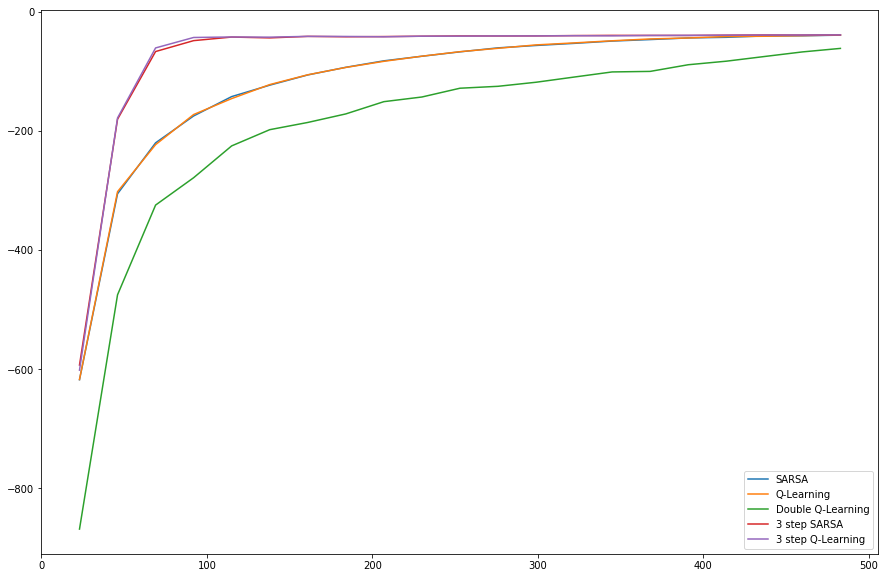

In [40]:
maze = MazeEnv(
    maze=np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0],
                   [0, 1, 0, 1, 0, 1, 1, 0, 1],
                   [0, 1, 1, 1, 0, 1, 0, 0, 0],
                   [0, 0, 0, 1, 0, 1, 1, 1, 0],
                   [1, 1, 0, 1, 0, 0, 1, 0, 0],
                   [0, 1, 0, 1, 1, 0, 1, 0, 1],
                   [0, 0, 0, 1, 0, 0, 1, 0, 0],
                   [1, 0, 1, 1, 0, 1, 1, 1, 0],
                   [0, 0, 0, 0, 0, 0, 1, 2, 0]]),
    start_pos=(0, 0)
)

plt.figure(figsize=(15, 10))

agents = [
    SARSA(default_value = 0., learning_rate = 0.1, reward_discount = 1., epsilon = 0.1),
    QLearning(default_value = 0., learning_rate = 0.1, reward_discount = 1., epsilon = 0.1),
    DoubleQLearning(default_value = 0., learning_rate = 0.1, reward_discount = 1., epsilon = 0.1),
    NStepSARSA(depth=2, default_value = 0., learning_rate = 0.1, reward_discount = 1., epsilon = 0.1),
    NStepSARSA(depth=3, default_value = 0., learning_rate = 0.1, reward_discount = 1., epsilon = 0.1),
    NStepQLearning(depth=3, default_value = 0., learning_rate = 0.1, reward_discount = 1., epsilon = 0.1)
]

for agent in agents:
    episodes, averages = train_agent(env=maze, agent=agent, nb_episodes=500)
    plt.plot(episodes, averages, label=agent.name())
    print("-" * 50)

plt.legend()
plt.show()

demo_agent(maze, agents[-1], gif_name='6_maze_example.gif')